In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import pandas as pd


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Dropout Regularization and Batch Normalization

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Dropout Regularization and Batch Normalization


In [6]:
data = pd.read_csv('Heterogeneous_accelerometer_HAR.csv')
data.shape

(3540962, 10)

In [7]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [8]:
data.isnull().any()

Index            False
Arrival_Time     False
Creation_Time    False
x                False
y                False
z                False
User             False
Model            False
Device           False
gt                True
dtype: bool

In [9]:
data.dropna(inplace = True)

In [10]:
data.isnull().any()

Index            False
Arrival_Time     False
Creation_Time    False
x                False
y                False
z                False
User             False
Model            False
Device           False
gt               False
dtype: bool

In [11]:
har = data[['x','y','z','gt']]

In [12]:
har.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [13]:
har['gt'].unique()

array(['stand', 'sit', 'walk', 'stairsup', 'stairsdown', 'bike'],
      dtype=object)

In [14]:
stand = har[har['gt'] == 'stand']

In [15]:
stand.head()

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand


In [16]:
stand.shape

(451189, 4)

In [17]:
stand = stand.iloc[0:5000,:]

In [18]:
stand.shape

(5000, 4)

In [19]:
sit = har[har['gt'] == 'sit'].iloc[0:5000,:]

In [20]:
walk = har[har['gt'] == 'walk'].iloc[0:5000,:]

In [21]:
stairsup = har[har['gt'] == 'stairsup'].iloc[0:5000,:]

In [22]:
stairsdown = har[har['gt'] == 'stairsdown'].iloc[0:5000,:]

In [23]:
bike = har[har['gt'] == 'bike'].iloc[0:5000,:]

In [24]:
harnew = pd.concat([stand, sit, walk, stairsup, stairsdown, bike])

In [25]:
harnew.shape

(30000, 4)

In [26]:
harnew

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,stand
1,-0.832584,-9.713276,-0.606930,stand
2,-1.018134,-9.935339,-0.544082,stand
3,-1.222838,-10.142437,-0.566229,stand
4,-1.577180,-10.480618,-0.402824,stand
...,...,...,...,...
32228,-7.964911,-0.887650,6.034586,bike
32229,-8.882488,-1.451485,6.030994,bike
32230,-8.641871,-1.823783,6.533178,bike
32231,-9.081207,-1.670554,7.043143,bike


In [27]:
harnew['gt'].replace(to_replace = 'stand', value = 0, inplace = True)
harnew['gt'].replace(to_replace = 'sit', value = 1, inplace = True)
harnew['gt'].replace(to_replace = 'walk', value = 2, inplace = True)
harnew['gt'].replace(to_replace = 'stairsup', value = 3, inplace = True)
harnew['gt'].replace(to_replace = 'stairsdown', value = 4, inplace = True)
harnew['gt'].replace(to_replace = 'bike', value = 5, inplace = True)

In [28]:
harnew

,x,y,z,gt
0,-0.565032,-9.572019,-0.614113,0
1,-0.832584,-9.713276,-0.606930,0
2,-1.018134,-9.935339,-0.544082,0
3,-1.222838,-10.142437,-0.566229,0
4,-1.577180,-10.480618,-0.402824,0
...,...,...,...,...
32228,-7.964911,-0.887650,6.034586,5
32229,-8.882488,-1.451485,6.030994,5
32230,-8.641871,-1.823783,6.533178,5
32231,-9.081207,-1.670554,7.043143,5


# Extracting Features and Labels

In [29]:
X = harnew[harnew.columns[0:-1]].values

In [30]:
X.shape

(30000, 3)

In [31]:
y = harnew[harnew.columns[-1]].values

In [32]:
y.shape

(30000,)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =42)

# Transform to Tensor and Using DataLoader

In [34]:
# Convert to tensor
train_data = torch.tensor(X_train).float()
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test).float()
test_labels = torch.tensor(y_test).long()


# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Place into dataloader
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size = test_data.tensors[0].shape[0])

# Observe the batches of training and test data

In [35]:
for X,y in train_loader:
    break
print(X.shape)
print(y.shape)

torch.Size([64, 3])
torch.Size([64])


In [36]:
print(y)

tensor([1, 4, 3, 1, 4, 3, 3, 3, 2, 4, 1, 5, 5, 1, 1, 0, 2, 2, 3, 4, 1, 4, 0, 1,
        3, 4, 0, 5, 4, 0, 1, 5, 1, 2, 2, 5, 3, 0, 4, 4, 0, 4, 5, 2, 5, 1, 1, 4,
        5, 5, 2, 3, 5, 0, 4, 5, 5, 2, 1, 1, 5, 0, 1, 3])


In [37]:
X,y = next(iter(test_loader))
print(X.shape)
print(y.shape)

torch.Size([6000, 3])
torch.Size([6000])


# Creating the Neural Network Model

In [38]:
model = nn.Sequential(
          nn.Linear(3,64),
          nn.ReLU(),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.Linear(32,16),
          nn.ReLU(),
          nn.Linear(16,6),
          )
model

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=6, bias=True)
)

# Training and Testing the model

In [39]:
epochs = 101
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9, lr=.001)

model.to(device)

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


for epoch in range(epochs):
 model.train()
 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device)
  y = y.to(device)


  ypred = model(X)
  loss = lossfun(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  batchLoss.append(loss.item())


  ypred = ypred.cpu()
  y = y.cpu()


  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

 trainAcc.append( np.mean(batchAcc) )

 losses[epoch] = np.mean(batchLoss)

# TESTING

 model.eval()
 X,y = next(iter(test_loader)) # Passing all the test samples to a model in one iteration

 X = X.to(device)
 y = y.to(device)

 with torch.no_grad():
  ypred = model(X)

  ypred = ypred.cpu()
  y = y.cpu()

  testAcc.append( 100*torch.mean((torch.argmax(ypred,dim=1)==y).float()) )
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.90
 epochs : 10  loss :  0.80
 epochs : 20  loss :  0.67
 epochs : 30  loss :  0.56
 epochs : 40  loss :  0.49
 epochs : 50  loss :  0.32
 epochs : 60  loss :  0.47
 epochs : 70  loss :  0.43
 epochs : 80  loss :  0.53
 epochs : 90  loss :  0.53
 epochs : 100  loss :  0.49


# Plotting and Visualizing the Results

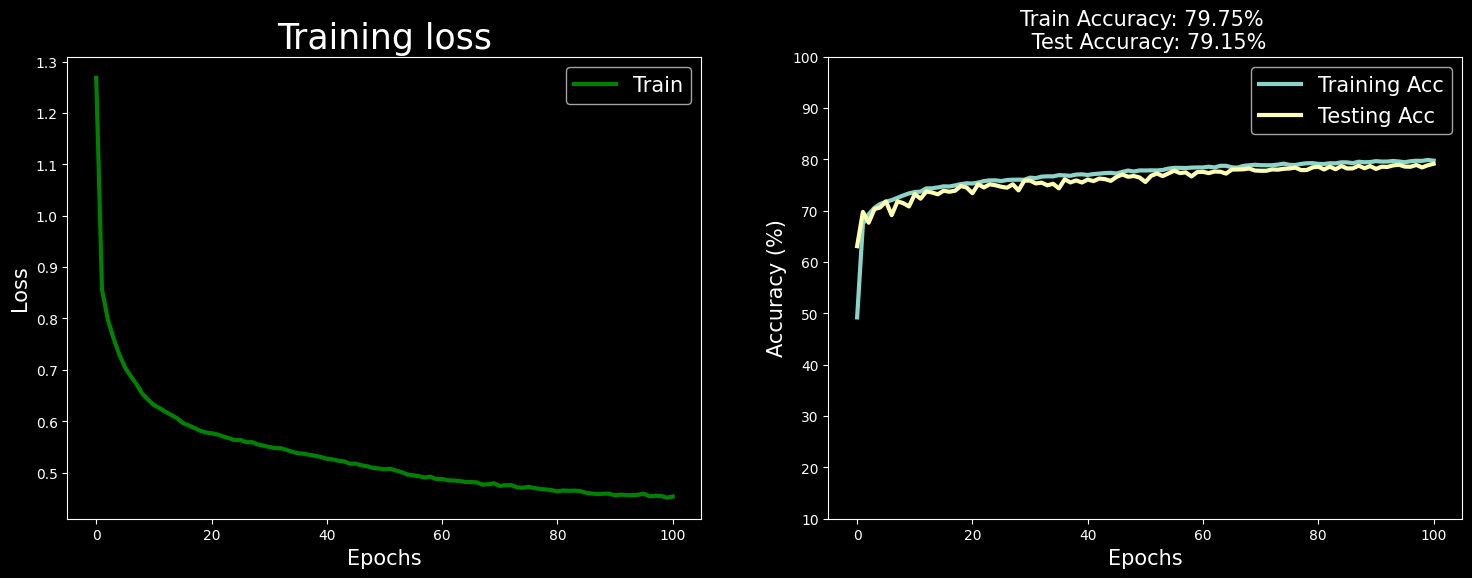

In [40]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

# Model With Batch Normalization

In [41]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(3, 64)

        # Hidden Layers

        self.fc1 = nn.Linear(64, 32)
        self.bnorm1 = nn.BatchNorm1d(64) # 64 are the input features of fc1
        self.fc2 = nn.Linear(32, 16)
        self.bnorm2 = nn.BatchNorm1d(32) # 32 are the input features of fc2

        # Output Layers

        self.output = nn.Linear(16, 6)

    def forward(self,x):

    # Pass the data through the model

        x = self.input(x)
        x = F.relu(x)

        # Hidden Layers

        x = self.bnorm1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bnorm2(x)
        x = self.fc2(x)
        x = F.relu(x)

        # output layer

        x = self.output(x)
        return x

# Create the instance of the model

In [42]:
model2 = Classifier()

# Training and Testing of the Model

In [43]:
epochs = 101
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(),momentum = 0.9, lr=.001)

model2.to(device)

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


for epoch in range(epochs):
 model2.train()
 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device)
  y = y.to(device)


  ypred = model2(X)
  loss = lossfun(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  batchLoss.append(loss.item())


  ypred = ypred.cpu()
  y = y.cpu()


  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

 trainAcc.append( np.mean(batchAcc) )

 losses[epoch] = np.mean(batchLoss)

# TESTING

 model2.eval()
 X,y = next(iter(test_loader))

 X = X.to(device)
 y = y.to(device)

 with torch.no_grad():
  ypred = model2(X)

  ypred = ypred.cpu()
  y = y.cpu()

  testAcc.append( 100*torch.mean((torch.argmax(ypred,dim=1)==y).float()) )
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.91
 epochs : 10  loss :  0.44
 epochs : 20  loss :  0.38
 epochs : 30  loss :  0.58
 epochs : 40  loss :  0.39
 epochs : 50  loss :  0.50
 epochs : 60  loss :  0.50
 epochs : 70  loss :  0.49
 epochs : 80  loss :  0.44
 epochs : 90  loss :  0.52
 epochs : 100  loss :  0.39


# Plotting and Visualization

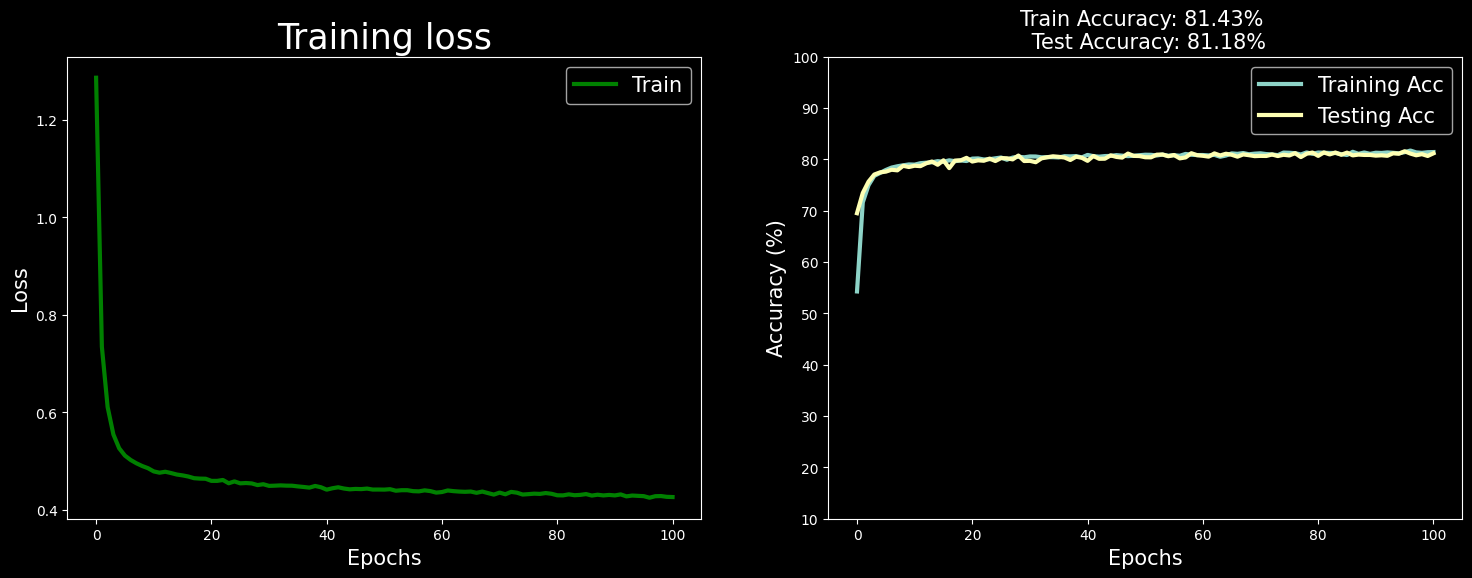

In [44]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()